In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from joblib import Parallel, delayed, parallel_backend
# from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn, down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_fn, CDF_RT_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz
import pickle
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_fn


from single_cond_utils import PA_with_LEDON_2_VEC
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_w_fn

import io
import matplotlib.gridspec as gridspec
import corner


In [2]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


In [3]:
# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')



# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of led off valid trials = 53472
len of valid trials < 1s : 52799


In [4]:
## VBMC params
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
del_go = 0.13 

# other params
K_max = 10

# LED Off - no noise
noise = 0


In [5]:
def compute_loglike_trial(row, gamma, omega, t_E_aff, w):
    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    response_poke = row['response_poke']
    

    t_pts = np.arange(t_stim, t_stim + 1, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts])
    area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts)
    trunc_factor_p_joint = area_btn_stim_and_1s
    
    bound_val = 2*response_poke - 5
    P_joint_rt_choice = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_fn(rt, t_LED, V_A, V_A_post_LED, theta_A,\
                                                                        gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, w, bound_val, K_max)
      
    
    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    
    wt_log_like = np.log(P_joint_rt_choice_trunc)


    return wt_log_like



In [6]:
omega_bounds = [0.05, 50]
omega_plausible_bounds = [0.5, 10]

t_E_aff_bounds = [0, 1]
t_E_aff_plausible_bounds = [0.01, 0.2]

w_bounds = [0.01, 0.99]
w_plausible_bounds = [0.3, 0.7]

In [7]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    gamma, omega, t_E_aff, w = params
    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    omega_logpdf = trapezoidal_logpdf(omega, omega_bounds[0], omega_plausible_bounds[0], omega_plausible_bounds[1], omega_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    w_logpdf = trapezoidal_logpdf(w, w_bounds[0], w_plausible_bounds[0], w_plausible_bounds[1], w_bounds[1])

    return gamma_logpdf + omega_logpdf + t_E_aff_logpdf + w_logpdf

In [ ]:
all_ABLs_cond = [20]
all_ILDs_cond = [1, -1]
for cond_ABL in all_ABLs_cond:
    for cond_ILD in all_ILDs_cond:
        conditions = {'ABL': [cond_ABL], 'ILD': [cond_ILD]}

        # Applying the filter
        df_led_off_valid_trials_cond_filtered = df_led_off_valid_trials[
            (df_led_off_valid_trials['ABL'].isin(conditions['ABL'])) & 
            (df_led_off_valid_trials['ILD'].isin(conditions['ILD']))
        ]


        def vbmc_loglike_fn(params):
            gamma, omega, t_E_aff, w = params

            all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, gamma, omega, t_E_aff, w) \
                                            for _, row in df_led_off_valid_trials_cond_filtered.iterrows())
            
            return np.sum(all_loglike)

        def vbmc_joint_fn(params):
            priors = vbmc_prior_fn(params)
            loglike = vbmc_loglike_fn(params)

            return priors + loglike

        
        print(f'++++++++++ ABL = {cond_ABL}, ILD = {cond_ILD} +++++++++++++++++++++')
        if cond_ILD > 0:
            gamma_bounds = [0.001, 5]
            gamma_plausible_bounds = [0.09, 0.9]
        elif cond_ILD < 0:
            gamma_bounds = [-5, -0.001]
            gamma_plausible_bounds = [-0.9, -0.09]


        lb = np.array([gamma_bounds[0], omega_bounds[0], t_E_aff_bounds[0], w_bounds[0]])
        ub = np.array([gamma_bounds[1], omega_bounds[1], t_E_aff_bounds[1], w_bounds[1]])

        plb = np.array([gamma_plausible_bounds[0], omega_plausible_bounds[0], t_E_aff_plausible_bounds[0], w_plausible_bounds[0]])
        pub = np.array([gamma_plausible_bounds[1], omega_plausible_bounds[1], t_E_aff_plausible_bounds[1], w_plausible_bounds[1]])

        # Initialize with random values within plausible bounds
        np.random.seed(42)
        gamma_0 = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
        omega_0 = np.random.uniform(omega_plausible_bounds[0], omega_plausible_bounds[1])
        t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
        w_0 = np.random.uniform(w_plausible_bounds[0], w_plausible_bounds[1])

        x_0 = np.array([gamma_0, omega_0, t_E_aff_0, w_0])

        # Run VBMC
        vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
        vp, results = vbmc.optimize()

        # save vbmc 
        vbmc.save(f'each_cond_data/vbmc_w_single_condn_ABL_{cond_ABL}_ILD_{cond_ILD}.pkl', overwrite=True)
        # Diagnostics

        vp_samples = vp.sample(int(1e5))[0]
        gamma_samples = vp_samples[:, 0]
        omega_samples = vp_samples[:, 1]
        t_E_aff_samples = vp_samples[:, 2]
        w_samples = vp_samples[:, 3]

        gamma = gamma_samples.mean()
        omega = omega_samples.mean()
        t_E_aff = t_E_aff_samples.mean()
        w = w_samples.mean()

        # corner plot
        corner_samples = np.vstack([gamma_samples, omega_samples, t_E_aff_samples, w_samples]).T
        percentiles = np.percentile(corner_samples, [0, 100], axis=0)
        _ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(corner_samples.shape[1])]
        param_labels = [ 'gamma', 'omega', 't_E_aff', 'w']

        fig_corner = corner.corner(
                    corner_samples,
                    labels=param_labels,
                    show_titles=True,
                    quantiles=[0.025, 0.5, 0.975],
                    range=_ranges,
                    title_fmt=".4f"
                );

        filename = f"corner_w_each_cond_ABL_{cond_ABL}_ILD_{cond_ILD}.png"
        save_path = os.path.join("each_cond_data", filename)
        fig_corner.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig_corner)

        # Diagnostics
        df_led_off = df[df['LED_trial'] == 0]
        # < 1s RTs
        df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]
        # remove truncated aborts
        data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]
        # renaming
        data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
            columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
        )

        ### ABORTS + VALID TRIALS + ABL, ILD CONDITION
        data_df_led_off_with_aborts_cond_filtered = data_df_led_off_with_aborts[
            (data_df_led_off_with_aborts['ABL'].isin(conditions['ABL'])) & 
            (data_df_led_off_with_aborts['ILD'].isin(conditions['ILD']))
        ]

        data_df_led_off_valid = data_df_led_off_with_aborts[ data_df_led_off_with_aborts['success'].isin([1,-1]) ]

        # VALID TRIALS CONDITION
        df_led_off_valid_trials_cond_filtered = data_df_led_off_valid[
            (data_df_led_off_valid['ABL'].isin(conditions['ABL'])) & 
            (data_df_led_off_valid['ILD'].isin(conditions['ILD']))
        ]

        df_led_off_valid_trials_cond_filtered['ABL'].unique(), df_led_off_valid_trials_cond_filtered['ILD'].unique()


        ### Diag 1 - Up and down ###
        N_theory = int(1e3)
        random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
        t_pts = np.arange(0, 1, 0.001)

        P_A_samples = np.zeros((N_theory, len(t_pts)))
        for idx in range(N_theory):
            t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
            pdf = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, t_stim, t_LED, t_A_aff)
            P_A_samples[idx, :] = pdf

        P_A_samples_mean = np.mean(P_A_samples, axis=0)
        C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

        up_wrt_stim = np.zeros_like(t_pts)
        down_wrt_stim = np.zeros_like(t_pts)
        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            
            up_wrt_stim[idx] =  up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, 1, K_max)
            down_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, -1, K_max)


        bins = np.arange(-1,1,0.02)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        ## data
        data_up = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == 1]
        data_down = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == -1]

        data_up_rt = data_up['rt'] - data_up['t_stim']
        data_up_rt_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)

        data_down_rt = data_down['rt'] - data_down['t_stim']
        data_down_rt_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

        frac_up_data = len(data_up) / len(df_led_off_valid_trials_cond_filtered)
        frac_down_data = len(data_down) / len(df_led_off_valid_trials_cond_filtered)

        theory_area_up = trapz(up_wrt_stim, t_pts)
        theory_area_down = trapz(down_wrt_stim, t_pts)


        # accuracy
        xlabels = ['data', 'vbmc']
        if conditions['ILD'][0] > 0:
            accuracy_data_and_theory = [frac_up_data, theory_area_up]
        else:
            accuracy_data_and_theory = [frac_down_data, theory_area_down]


        ### tacho ###
        tacho = np.zeros_like(t_pts)
        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            
            P_up = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, 1, K_max)
            P_down = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, -1, K_max)
            
            if conditions['ILD'][0] > 0:
                P_rt_c = P_up
            else:
                P_rt_c = P_down
                
            P_rt = P_up + P_down
            tacho[idx] = P_rt_c / P_rt

        df_led_off_valid_trials_cond_filtered_copy = df_led_off_valid_trials_cond_filtered.copy()
        df_led_off_valid_trials_cond_filtered_copy.loc[:, 'RT_bin'] = pd.cut(df_led_off_valid_trials_cond_filtered_copy['rt'] - df_led_off_valid_trials_cond_filtered_copy['t_stim'],\
                                                                    bins = bins, include_lowest=True)
        grouped_by_rt_bin = df_led_off_valid_trials_cond_filtered_copy.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
        grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)

        ### Plot ###
        FONT_SIZE_LABEL = 22   # for x/y labels
        FONT_SIZE_TICKS = 22   # for x/y tick labels
        FONT_SIZE_TITLE = 22   # for subplot titles
        FONT_SIZE_INSET_TITLE = 22  # for inset bar plot title

        # --------------------------
        # Create a figure and a GridSpec with 3 columns,
        # giving the third column more space (e.g., 1.4 times the width).
        fig = plt.figure(figsize=(30, 8))
        gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 1, 1.4])

        ax_rtd = fig.add_subplot(gs[0, 0])
        ax_tacho = fig.add_subplot(gs[0, 1])
        ax_corner = fig.add_subplot(gs[0, 2])

        # ------------------------------------------------------------------------------
        # 1) RTD Plot in ax_rtd
        ax_rtd.plot(t_pts, up_wrt_stim, ls='--', color='r')
        ax_rtd.plot(t_pts, -down_wrt_stim, ls='--', color='r')
        ax_rtd.plot(bin_centers, data_up_rt_hist * frac_up_data, color='b')
        ax_rtd.plot(bin_centers, -data_down_rt_hist * frac_down_data, color='b')

        ax_rtd.set_xlim(0, 1)

        # Set labels and title with custom font sizes
        ax_rtd.set_xlabel('rt wrt stim', fontsize=FONT_SIZE_LABEL)
        ax_rtd.set_ylabel('density', fontsize=FONT_SIZE_LABEL)
        ax_rtd.set_title(
            f"Areas: +T:{theory_area_up:.3f},+E:{frac_up_data:.3f},"
            f"-T:{theory_area_down:.3f},-E:{frac_down_data:.3f}",
            fontsize=FONT_SIZE_TITLE
        )

        # Increase tick label size
        ax_rtd.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)

        # Inset bar chart
        inset_ax = ax_rtd.inset_axes([0.65, 0.55, 0.3, 0.4])
        bar_positions = [0, 1]
        inset_ax.bar(bar_positions, accuracy_data_and_theory, color=['C0', 'C1'])
        inset_ax.set_xticks(bar_positions)
        inset_ax.set_xticklabels(['data', 'vbmc'], fontsize=FONT_SIZE_TICKS)
        inset_ax.set_ylim(0, 1)
        inset_ax.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
        inset_ax.set_title(
            f"AL={conditions['ABL'][0]},ID={conditions['ILD'][0]}",
            fontsize=FONT_SIZE_INSET_TITLE
        )
        inset_ax.tick_params(axis='y', which='major', labelsize=FONT_SIZE_TICKS)

        # ------------------------------------------------------------------------------
        # 2) Tacho Plot in ax_tacho
        ax_tacho.plot(t_pts, tacho, label='tacho')
        ax_tacho.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')
        ax_tacho.set_ylim(0.5, 1)

        # Set labels and title with custom font sizes
        ax_tacho.set_xlabel('rt - t_stim', fontsize=FONT_SIZE_LABEL)
        ax_tacho.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
        ax_tacho.set_title('btn stim start and stim + 1s', fontsize=FONT_SIZE_TITLE)

        # Increase tick label size
        ax_tacho.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)
        ax_tacho.legend(fontsize=FONT_SIZE_TICKS)


        ## 3. Corner
        fig_corner = corner.corner(
            corner_samples,
            labels=['Γ', 'ω', 'tE', 'w'],
            show_titles=True,
            quantiles=[0.025, 0.5, 0.975],
            range=_ranges,
            title_fmt=".4f",
            title_kwargs={"fontsize": 18}
        )

        # Adjust subplots to reduce margins around the corner plot.
        # Tweak left, right, bottom, top until the left whitespace is minimized.
        fig_corner.subplots_adjust(left=0, right=0.95, bottom=0.15, top=0.9)

        # Save with minimal padding
        buf = io.BytesIO()
        fig_corner.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)

        # Read into an image array and close the figure
        corner_img = plt.imread(buf)
        plt.close(fig_corner)

        # Now display in your third subplot
        ax_corner.imshow(corner_img)
        ax_corner.axis('off')
        ax_corner.set_title('Corner Plot', fontsize=20, pad=0)

        fname = f'each_cond_data/diagnostics_w_ABL_{cond_ABL}_ILD_{cond_ILD}.png'
        plt.savefig(fname, dpi=300, bbox_inches="tight")

In [8]:
from docx import Document
from docx.shared import Inches
import os

def create_docx_report(abl_value, ild_values, image_folder="."):
    """
    Creates a DOCX report with diagnostics and corner plots for each ILD for a given ABL.

    Args:
        abl_value (int): The ABL value.
        ild_values (list): A list of ILD values.
        image_folder (str, optional): The folder containing the image files. Defaults to ".".
    """

    docx_filename = f"w_ABL_{abl_value}_report.docx"
    document = Document()

    # Title page
    document.add_heading(f'ABL {abl_value}', level=1)
    document.add_page_break()

    # Iterate through ILDs
    for ild_value in ild_values:
        diagnostics_filename = os.path.join(image_folder, f"diagnostics_w_ABL_{abl_value}_ILD_{ild_value}.png")
        corner_filename = os.path.join(image_folder, f"corner_w_each_cond_ABL_{abl_value}_ILD_{ild_value}.png")

        document.add_heading(f'ILD {ild_value}', level=2) # Subheading for ILD

        if os.path.exists(diagnostics_filename) and os.path.exists(corner_filename):
            document.add_picture(diagnostics_filename, width=Inches(5)) # Adjust width as needed
            document.add_picture(corner_filename, width=Inches(5)) # Adjust width as needed
        else:
            document.add_paragraph(f"Images not found for ILD {ild_value}")

        document.add_page_break() # New page for each ILD

    document.save(docx_filename)
    print(f"DOCX report created: {docx_filename}")


all_ABLs_cond = [20, 40, 60]
ild_values = [1, -1, 2, -2, 4, -4, 8, -8, 16, -16]

for abl_value in all_ABLs_cond:
    image_folder = "each_cond_data" # Assuming images are in 'each_cond_data' folder
    create_docx_report(abl_value, ild_values, image_folder)

DOCX report created: w_ABL_20_report.docx
DOCX report created: w_ABL_40_report.docx
DOCX report created: w_ABL_60_report.docx


# plot param vs ILd for each ABl

In [8]:
all_ABL = [20, 40, 60]
# all_ABL = [20]
all_ILD_sorted = np.sort([1, -1, 2, -2, 4, -4, 8, -8, 16, -16])
gamma_vs_ILD_for_each_ABL = np.zeros((len(all_ABL),len(all_ILD_sorted)))
omega_vs_ILD_for_each_ABL = np.zeros((len(all_ABL),len(all_ILD_sorted)))
t_E_aff_vs_ILD_for_each_ABL = np.zeros((len(all_ABL),len(all_ILD_sorted)))
w_vs_ILD_for_each_ABL = np.zeros((len(all_ABL),len(all_ILD_sorted)))

In [9]:
for a_idx, abl in enumerate(all_ABL):
    for i_idx, ILD in enumerate(all_ILD_sorted):
        pkl_file = os.path.join('each_cond_data', f"vbmc_w_single_condn_ABL_{abl}_ILD_{ILD}.pkl")
        with open(pkl_file, 'rb') as f:
            vp = pickle.load(f)
        vp = vp.vp
        vp_samples = vp.sample(int(1e5))[0]
        
        gamma_vs_ILD_for_each_ABL[a_idx, i_idx] = vp_samples[:, 0].mean()
        omega_vs_ILD_for_each_ABL[a_idx, i_idx] = vp_samples[:, 1].mean()
        t_E_aff_vs_ILD_for_each_ABL[a_idx, i_idx] = vp_samples[:, 2].mean() * 1000
        w_vs_ILD_for_each_ABL[a_idx, i_idx] = vp_samples[:, 3].mean()


In [10]:
def calc_gamma_vs_ILD(params):
    rate_lambda, T0, theta_E = params
    return rate_lambda * theta_E * all_ILD_sorted / 17.37

def calc_omega_vs_ABL(params, ABL):
    rate_lambda, T0, theta_E = params
    return (2 / (T0 * (theta_E**2))) * (10**(rate_lambda*ABL/20))

juan_eye_fit_params = [0.118, 1/2220, 45]
vbmc_fit_params = [0.1310, 0.8378*1e-3, 33.7890]

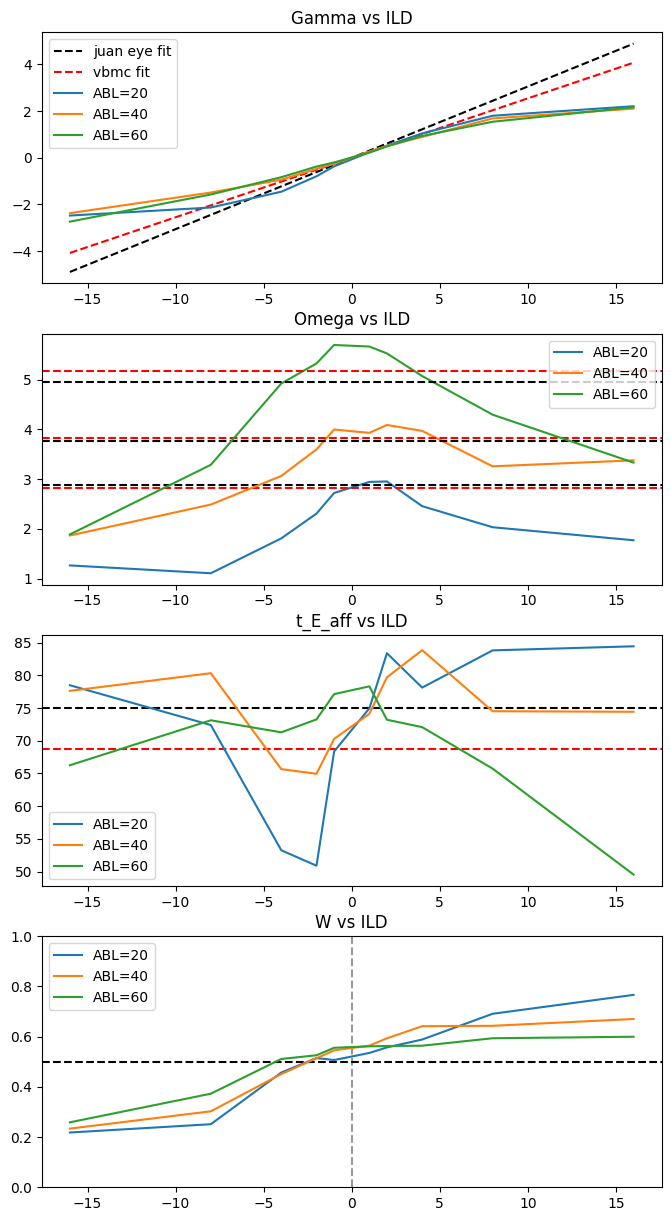

In [11]:
# rate_lambda = 0.118
# T_0 = 1/2220
# theta_E = 45

plt.figure(figsize=(8, 15))
plt.subplot(4, 1, 1)
plt.plot(all_ILD_sorted, calc_gamma_vs_ILD(juan_eye_fit_params), label='juan eye fit', ls='--', color='k')
plt.plot(all_ILD_sorted, calc_gamma_vs_ILD(vbmc_fit_params), label='vbmc fit', ls='--', color='r')
for a_idx, ABL in enumerate(all_ABL):
    plt.plot(all_ILD_sorted, gamma_vs_ILD_for_each_ABL[a_idx, :], label=f'ABL={ABL}')

    plt.title('Gamma vs ILD')
    plt.legend()


plt.subplot(4, 1, 2)
for a_idx, ABL in enumerate(all_ABL):
    plt.plot(all_ILD_sorted, omega_vs_ILD_for_each_ABL[a_idx, :], label=f'ABL={ABL}')
    
    plt.axhline(calc_omega_vs_ABL(juan_eye_fit_params, ABL), color='k', ls='--')
    plt.axhline(calc_omega_vs_ABL(vbmc_fit_params, ABL), color='r', ls='--')

    plt.title('Omega vs ILD')
    plt.legend()


plt.subplot(4, 1, 3)
plt.axhline(75, color='k', ls='--')
plt.axhline(68.7, color='r', ls='--')
for a_idx, ABL in enumerate(all_ABL):
    plt.plot(all_ILD_sorted, t_E_aff_vs_ILD_for_each_ABL[a_idx, :], label=f'ABL={ABL}')
    

    plt.title('t_E_aff vs ILD')
    plt.legend()

plt.subplot(4,1,4)
plt.axhline(0.5, color='k', ls='--')
plt.axvline(0, color='k', ls='--', alpha=0.4)
for a_idx, ABL in enumerate(all_ABL):
    plt.plot(all_ILD_sorted, w_vs_ILD_for_each_ABL[a_idx, :], label=f'ABL={ABL}')
    

    plt.title('W vs ILD')
    plt.legend()
    plt.ylim(0,1)


# plot RTD to see if bimmodality is present

In [13]:
all_ABL = [20, 40, 60]
# all_ABL = [20]
all_ILD = np.array([1, -1, 2, -2, 4, -4, 8, -8, 16, -16])

In [14]:
# PA
### Diag 1 - Up and down ###
N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 1, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, t_stim, t_LED, t_A_aff)
    P_A_samples[idx, :] = pdf

P_A_samples_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

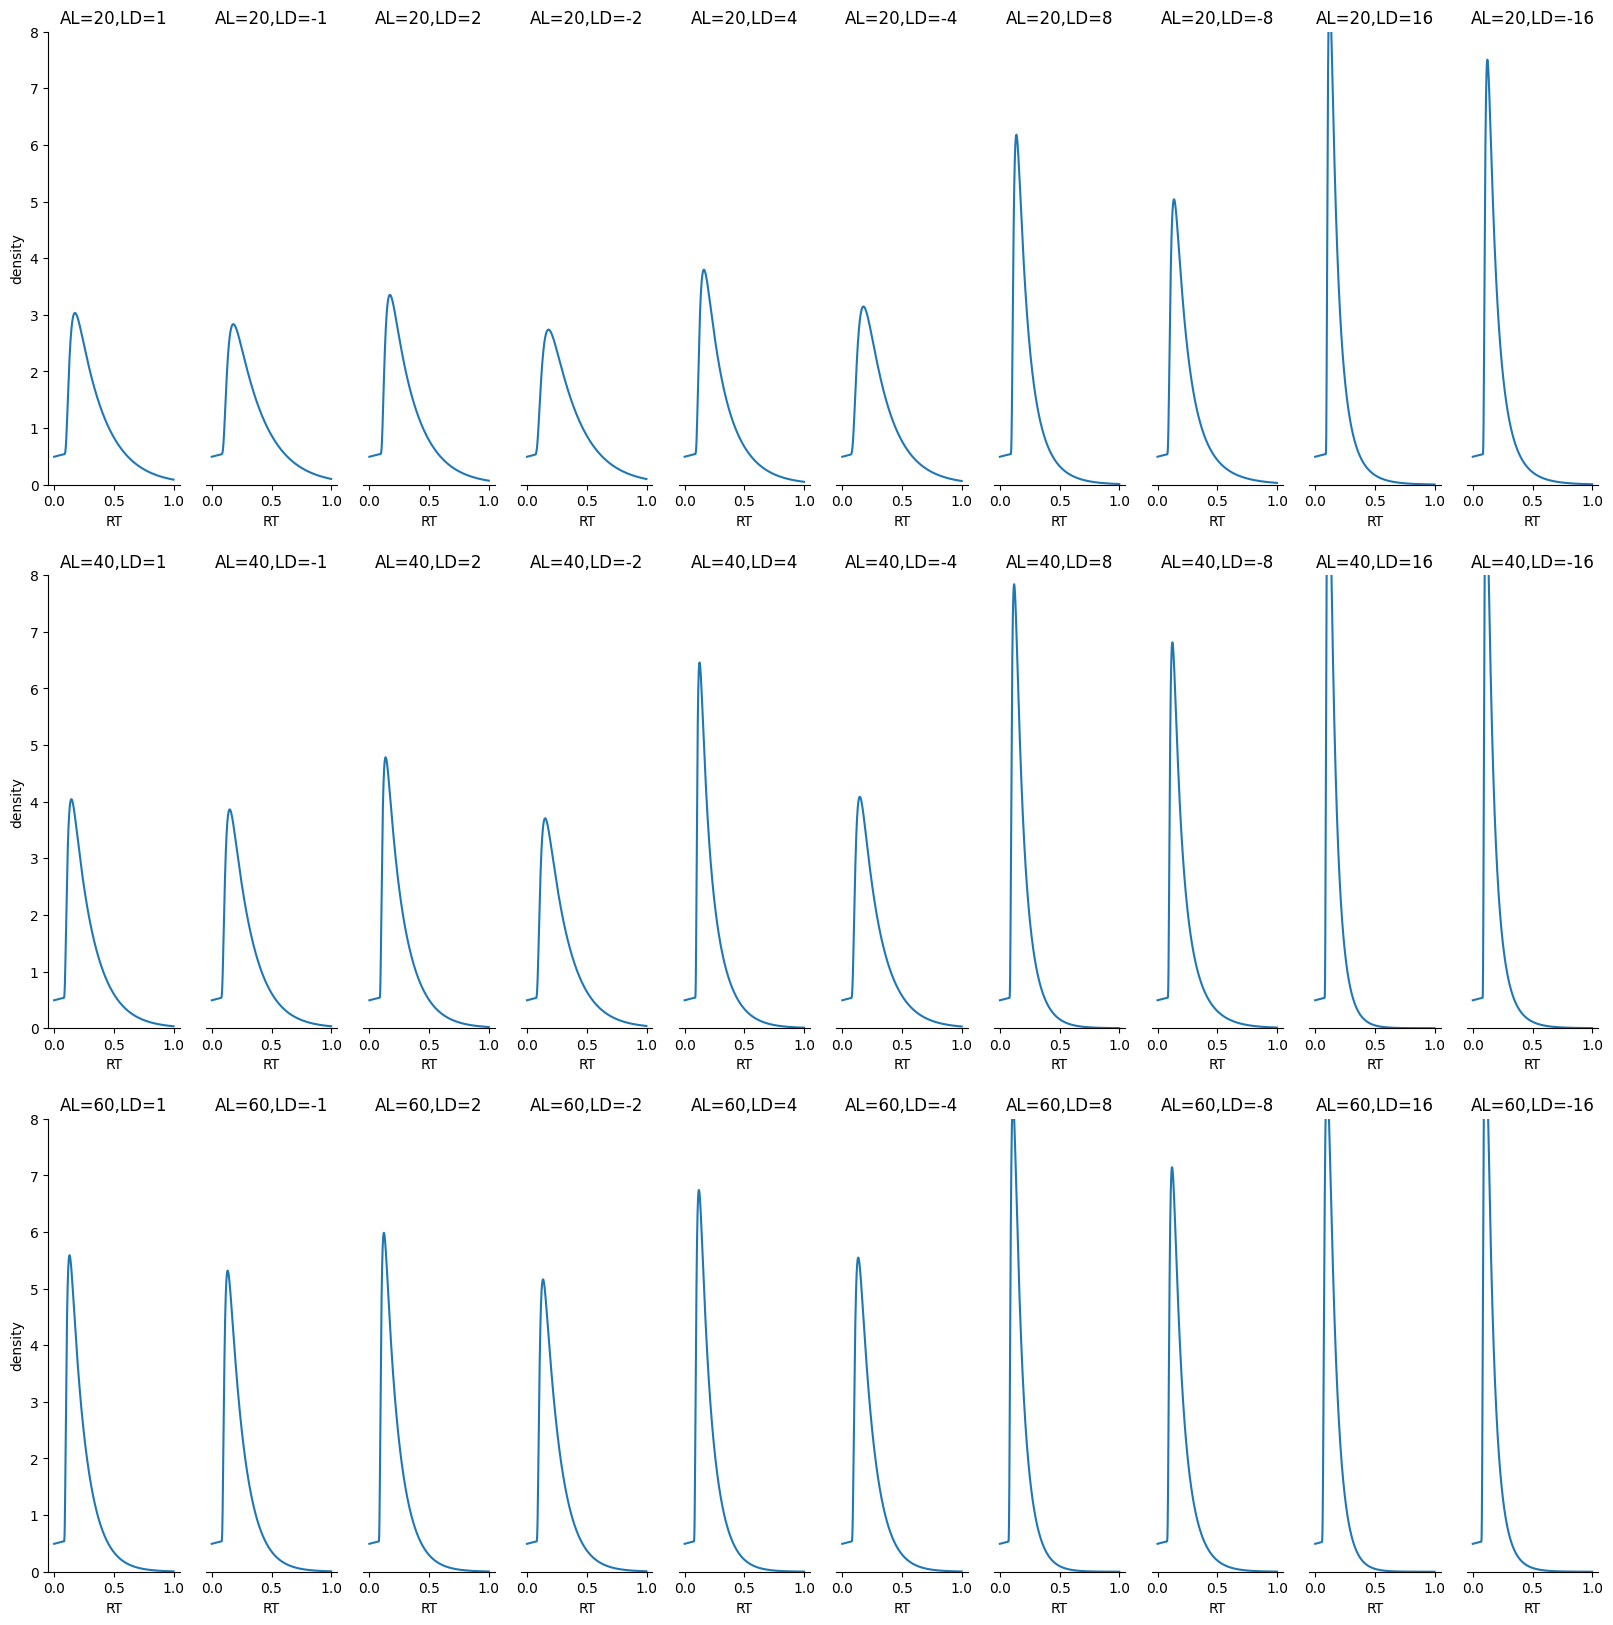

In [20]:
plt.figure(figsize=(20, 20))
fig_num = 1
for a_idx, ABL in enumerate(all_ABL):
    for i_idx, ILD in enumerate(all_ILD):
        ax = plt.subplot(len(all_ABL), len(all_ILD), fig_num)

        pkl_file = os.path.join('each_cond_data', f"vbmc_w_single_condn_ABL_{ABL}_ILD_{ILD}.pkl")
        with open(pkl_file, 'rb') as f:
            vp = pickle.load(f)
        vp = vp.vp
        vp_samples = vp.sample(int(1e5))[0]

        gamma_samples = vp_samples[:, 0]
        omega_samples = vp_samples[:, 1]
        t_E_aff_samples = vp_samples[:, 2]
        w_samples = vp_samples[:, 3]

        gamma = gamma_samples.mean()
        omega = omega_samples.mean()
        t_E_aff = t_E_aff_samples.mean()
        w = w_samples.mean()

        up_wrt_stim = np.zeros_like(t_pts)
        down_wrt_stim = np.zeros_like(t_pts)
        for idx, t in enumerate(t_pts):
            P_A = P_A_samples_mean[idx]
            C_A = C_A_mean[idx]
            
            up_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(
                t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, 1, K_max)
            down_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(
                t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, -1, K_max)

        rtd = up_wrt_stim + down_wrt_stim

        ax.plot(t_pts, rtd)
        ax.set_title(f'AL={ABL},LD={ILD}')
        ax.set_xlabel('RT')
        ax.set_ylabel('density' if i_idx == 0 else "")
        ax.set_ylim(0, 8)

        # Remove right, top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Remove y-axis for all but the first column
        if i_idx != 0:
            ax.spines['left'].set_visible(False)
            ax.set_yticks([])

        fig_num += 1
